In [5]:
# %matplotlib inline
# python libraries
import cv2
import os,itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("C:/Users/IMRAN/Partion 2/UNHAS/MKPK/KP/WEEK3/Dataset/ISIC_2019_Training_Input"))

ImportError: cannot import name 'deferred_error' from 'PIL._util' (C:\ProgramData\anaconda3\envs\CUDAGPU\lib\site-packages\PIL\_util.py)

# Feature eng and data preprocessing

In [6]:
data_dir = 'C:/Users/IMRAN/Partion 2/UNHAS/MKPK/KP/WEEK3/Dataset/ISIC_2019_Training_Input'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
#extracts the image id to match it with the .csv label file
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0] : x for x in all_image_path}
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevi',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'BKL': 'Benign keratosis ',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesions',
    'SCC' : 'Squamous cell carcinoma',
    'UNK' : 'Unknown'
}
input_size = 224

NameError: name 'glob' is not defined

In [3]:
# {os.path.splitext(os.path.basename(x))[0] : x for x in all_image_path}

In [4]:
#use this training model from scratch or not using pretrained model
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [5]:
# mean, std = compute_img_mean_std(all_image_path)
mean = [0.6674008, 0.5293524, 0.524005]
std = [0.22350508, 0.20349441, 0.2151846]

In [6]:
# pd.read_csv(os.path.join(data_dir,'HAM10000_metadata.csv'))

In [7]:
data_dir = '../input/isic-2019'

df = pd.read_csv("C:/Users/IMRAN/Partion 2/UNHAS/MKPK/KP/WEEK3/Dataset/ISIC_2019_Training_GroundTruth.csv")

for i, row in df.iterrows():
    header = row.index[row == 1.0][0]
    df.at[i, 'cell_type'] = header
    df.at[i, 'path'] ="C:/Users/IMRAN/Partion 2/UNHAS/MKPK/KP/WEEK3/Dataset/ISIC_2019_Training_Input/"+row['image']+".jpg"


In [8]:
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,cell_type,path
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...


In [9]:
#creating three new columns image_path (path)
#disease type full name from lesion_types (cell_type)
#categorical code of label or disease type (cell_type_idx)
# .map maps value from keys
#.get returns all values
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,cell_type,path,cell_type_idx
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4


In [10]:
 df.groupby('image').count()

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,cell_type,path,cell_type_idx
image,,,,,,,,,,,,
ISIC_0000000,1,1,1,1,1,1,1,1,1,1,1,1
ISIC_0000001,1,1,1,1,1,1,1,1,1,1,1,1
ISIC_0000002,1,1,1,1,1,1,1,1,1,1,1,1
ISIC_0000003,1,1,1,1,1,1,1,1,1,1,1,1
ISIC_0000004,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_0073247,1,1,1,1,1,1,1,1,1,1,1,1
ISIC_0073248,1,1,1,1,1,1,1,1,1,1,1,1
ISIC_0073249,1,1,1,1,1,1,1,1,1,1,1,1


Duplicates have same HAM number or lesion id
Hence they have more than 1 count values under groupby

In [11]:
#finding number of images in each group
ndf = df.groupby('image').count()
#finding out lesion id that have only one image
#ndf = ndf[ndf['image']==1]
#ndf.head()

In [12]:
ndf.reset_index(inplace=True)
ndf.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,cell_type,path,cell_type_idx
0,ISIC_0000000,1,1,1,1,1,1,1,1,1,1,1,1
1,ISIC_0000001,1,1,1,1,1,1,1,1,1,1,1,1
2,ISIC_0000002,1,1,1,1,1,1,1,1,1,1,1,1
3,ISIC_0000003,1,1,1,1,1,1,1,1,1,1,1,1
4,ISIC_0000004,1,1,1,1,1,1,1,1,1,1,1,1


In [13]:
#identify ones with duplicate images and only one image
def get_duplicate(x):
    uniq = list(ndf['image'])
    if x in uniq:
        return 'unduplicate'
    return 'duplicated'

#new column of lesion id
df['duplicates'] = df['image']
#applying function to this column
df['duplicates'] = df['duplicates'].apply(get_duplicate)
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,cell_type,path,cell_type_idx,duplicates
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4,unduplicate
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4,unduplicate


In [14]:
df['duplicates'].value_counts()

unduplicate    25331
Name: duplicates, dtype: int64

In [15]:
#filtering images which are not duplicated
df_undup = df[df['duplicates']=='unduplicate']
df_undup.shape

(25331, 14)

In [16]:
#creating validation set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.20,random_state=101, stratify=y)
df_val.shape

(5067, 14)

In [17]:
df_val['cell_type_idx'].value_counts()

5    2575
4     904
1     665
2     525
0     173
6     126
7      51
3      48
Name: cell_type_idx, dtype: int64

In [18]:
#creating training set on df (including duplicates)
#Function identifies if an image is part of the train or val set.
def get_val_rows(x):
    val_list = list(df_val['image'])
    if str(x) in val_list:
        return 'val'
    return 'train'

#applying it
df['train_or_val'] = df['image']
df['train_or_val'] = df['train_or_val'].apply(get_val_rows)
#filter out train rows
df_train = df[df['train_or_val']=='train']
len(df_train), len(df_val)

(20264, 5067)

In [19]:
df_train['cell_type_idx'].value_counts(), df_val['cell_type'].value_counts()

(5    10300
 4     3618
 1     2658
 2     2099
 0      694
 6      502
 7      202
 3      191
 Name: cell_type_idx, dtype: int64,
 NV      2575
 MEL      904
 BCC      665
 BKL      525
 AK       173
 SCC      126
 VASC      51
 DF        48
 Name: cell_type, dtype: int64)

as seen above there is a serious imbalance in images per class

In [20]:
df_train.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,cell_type,path,cell_type_idx,duplicates,train_or_val
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4,unduplicate,train
5,ISIC_0000006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
6,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
7,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train


In [21]:
import pandas as pd
#Creating copies to balance
data_aug_rate = [4,0,0,12,0,0,5,12]
for i in range(8):
    if data_aug_rate[i]>0:
        df_train = df_train.append([df_train.loc[df_train['cell_type_idx']==i,:]]*(data_aug_rate[i]-1),ignore_index=True)

df_train = df_train.drop(df_train[df_train['cell_type_idx'] == 5].sample(frac=0.8).index)


/tmp/ipykernel_23/238117541.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append([df_train.loc[df_train['cell_type_idx']==i,:]]*(data_aug_rate[i]-1),ignore_index=True)


In [22]:
df_train['cell_type'].value_counts()

MEL     3618
AK      2776
BCC     2658
SCC     2510
VASC    2424
DF      2292
BKL     2099
NV      2060
Name: cell_type, dtype: int64

In [23]:
df_train.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,cell_type,path,cell_type_idx,duplicates,train_or_val
1,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4,unduplicate,train
3,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
4,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
11,ISIC_0000016,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
17,ISIC_0000022_downsampled,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4,unduplicate,train


In [24]:
df_train.reset_index().head()

,index,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,cell_type,path,cell_type_idx,duplicates,train_or_val
0,1,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4,unduplicate,train
1,3,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
2,4,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
3,11,ISIC_0000016,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
4,17,ISIC_0000022_downsampled,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4,unduplicate,train


In [25]:
df_train=df_train.reset_index()
df_val=df_val.reset_index()


In [26]:
df_train.head()

,index,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,cell_type,path,cell_type_idx,duplicates,train_or_val
0,1,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4,unduplicate,train
1,3,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
2,4,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
3,11,ISIC_0000016,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,../input/isic-2019/ISIC_2019_Training_Input/IS...,5,unduplicate,train
4,17,ISIC_0000022_downsampled,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,../input/isic-2019/ISIC_2019_Training_Input/IS...,4,unduplicate,train




# Model Building

In [27]:
# transfer learning 
#learning by updating pre trained weights or not and updating last layer only
def set_para_req_grad(model, grad):
    if grad == True:
        for param in mode.parameters():
            param.requires_grad = False

In [28]:
models.resnet50(),models.densenet121()

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

In [29]:
def initialise_model(model_name, num_classes, grad, use_pretrained=True):
    '''
    grad = if the pretrained weights be updated
    use_pretrained = use pre trained weights or start from scratch
    '''
    model = None
    
    if model_name == 'resnet':
        model = models.resnet50(pretrained=use_pretrained)
        set_para_req_grad(model, grad)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet':
        model = models.densenet121(pretrained=use_pretrained)
        set_para_req_grad(model,grad)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    return model

In [30]:
num_classes = 8
model_name = 'densenet'
grad = False
#initialise model to run
model = initialise_model(model_name, num_classes, grad, use_pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 84.1MB/s]


In [31]:
#training model on gpu 
device = torch.device('cuda:0')
model = model.to(device)

In [32]:
#if not training from scratch and using pretrained
#mean = (0.49139968, 0.48215827, 0.44653124)
#std = (0.24703233, 0.24348505, 0.26158768)
#data augmentation
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean,std)])

In [33]:
#dataloader or dataset
class HAM1000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self, index):
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))
        
        if self.transform:
            X = self.transform(X)
        return X,y

In [34]:
import pprint


#dataset
train_ds = HAM1000(df_train, transform=train_transform)
val_ds = HAM1000(df_val, transform=val_transform)

val_ds.df.head()
batch_size = 32
epochs = 10
lr = 1e-3

#dataloader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,num_workers=4)
val_dl = DataLoader(val_ds, batch_size=batch_size,shuffle=False, num_workers=4)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
print(df_train)

       index                     image  MEL   NV  BCC   AK  BKL   DF  VASC  \
0          1              ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0   
1          3              ISIC_0000007  0.0  1.0  0.0  0.0  0.0  0.0   0.0   
2          4              ISIC_0000008  0.0  1.0  0.0  0.0  0.0  0.0   0.0   
3         11              ISIC_0000016  0.0  1.0  0.0  0.0  0.0  0.0   0.0   
4         17  ISIC_0000022_downsampled  1.0  0.0  0.0  0.0  0.0  0.0   0.0   
...      ...                       ...  ...  ...  ...  ...  ...  ...   ...   
20432  28672              ISIC_0072479  0.0  0.0  0.0  0.0  0.0  0.0   1.0   
20433  28673              ISIC_0072651  0.0  0.0  0.0  0.0  0.0  0.0   1.0   
20434  28674              ISIC_0073012  0.0  0.0  0.0  0.0  0.0  0.0   1.0   
20435  28675              ISIC_0073031  0.0  0.0  0.0  0.0  0.0  0.0   1.0   
20436  28676              ISIC_0073110  0.0  0.0  0.0  0.0  0.0  0.0   1.0   

       SCC  UNK cell_type                                      

In [36]:
lr = 1e-3

# optimiser and criterion
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

# Training


In [37]:
#Loss and accuracy calculator
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum/self.count

In [38]:
tloss_train , tacc_train =[],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch-1)*len(train_dl)
    
    for i,data in enumerate(train_loader):
        images, labels = data
        n = images.size(0)
        
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
     
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        pred = torch.argmax(outputs,dim=1)
        train_acc.update(pred.eq(labels).sum().item()/n)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i+1)%100 == 0:
            print(f'epoch {epoch} [iter {i+1}/{len(train_dl)}] [train loss {train_loss.avg:.5f}] [train acc {train_acc.avg:.5f}]')
            tloss_train.append(train_loss.avg)
            tacc_train.append(train_acc.avg)
        
    return train_loss.avg, train_acc.avg

In [39]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            n = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            
            output = model(images)
            pred = torch.argmax(output, dim=1)
            
            val_acc.update(pred.eq(labels).sum().item()/n)
            val_loss.update(criterion(output, labels).item())
            
        print('-----------------------------------------')
        print(f'[epoch {epoch}] [iter{i/len(val_dl)}] [val loss {val_loss.avg:.5f}] [val_acc {val_acc.avg:.5f}]')
        print('-----------------------------------------')
            
        return val_loss.avg, val_acc.avg

In [40]:
best_val_acc = 0
tloss_val, tacc_val = [],[]

for epoch in range(epochs):
    
    loss_train, acc_train = train(train_dl, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_dl, model, criterion, optimizer, epoch)
    tloss_val.append(loss_val)
    tacc_val.append(acc_val)

    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('******************')
        print(f'best [epoch{epoch}] [loss {loss_val:.5f}] [acc {acc_val:.5f}]')
        print('******************')

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 0 [iter 100/639] [train loss 1.69940] [train acc 0.35563]
epoch 0 [iter 200/639] [train loss 1.59088] [train acc 0.39984]
epoch 0 [iter 300/639] [train loss 1.53069] [train acc 0.42208]
epoch 0 [iter 400/639] [train loss 1.48102] [train acc 0.44453]
epoch 0 [iter 500/639] [train loss 1.44163] [train acc 0.46319]
epoch 0 [iter 600/639] [train loss 1.41133] [train acc 0.47677]
-----------------------------------------
[epoch 0] [iter0.9937106918238994] [val loss 1.31080] [val_acc 0.51856]
-----------------------------------------
******************
best [epoch0] [loss 1.31080] [acc 0.51856]
******************
epoch 1 [iter 100/639] [train loss 1.19076] [train acc 0.55500]
epoch 1 [iter 200/639] [train loss 1.18079] [train acc 0.55719]
epoch 1 [iter 300/639] [train loss 1.16404] [train acc 0.56188]
epoch 1 [iter 400/639] [train loss 1.14717] [train acc 0.56844]
epoch 1 [iter 500/639] [train loss 1.13155] [train acc 0.57556]
epoch 1 [iter 600/639] [train loss 1.11965] [train acc 0.57

# Model evaluation

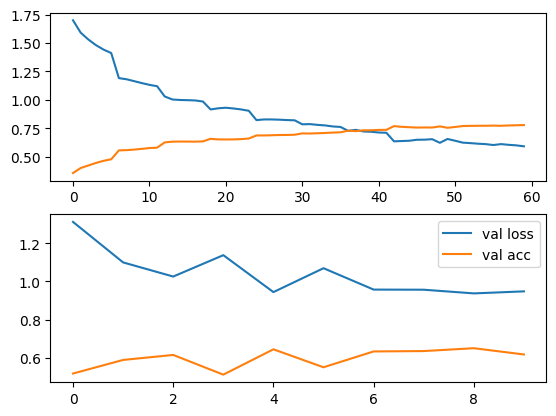

In [41]:
fig = plt.figure(num=2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)

fig1.plot(tloss_train, label='training loss')
fig1.plot(tacc_train, label='training acc')

fig2.plot(tloss_val, label='val loss')
fig2.plot(tacc_val, label='val acc')

plt.legend()
plt.show()

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<built-in method size of Tensor object at 0x7a599dcb1e40>
<built-in method size of Tensor object at 0x7a599fc19df0>
<built-in method size of Tensor object at 0x7a59a06b4090>
<built-in method size of Tensor object at 0x7a59a06e9fd0>
<built-in method size of Tensor object at 0x7a599dcb2520>
<built-in method size of Tensor object at 0x7a599dcb1ee0>
<built-in method size of Tensor object at 0x7a599dcb26b0>
<built-in method size of Tensor object at 0x7a599dcb25c0>
<built-in method size of Tensor object at 0x7a599dcb1710>
<built-in method size of Tensor object at 0x7a599dcb2200>
<built-in method size of Tensor object at 0x7a59a06317b0>
<built-in method size of Tensor object at 0x7a599dcb2750>
<built-in method size of Tensor object at 0x7a599dcb2890>
<built-in method size of Tensor object at 0x7a599dcb2840>
<built-in method size of Tensor object at 0x7a599dcb2a70>
<built-in method size of Tensor object at 0x7a599dcb27a0>
<built-in method size of Tensor object at 0x7a599dcb2930>
<built-in meth

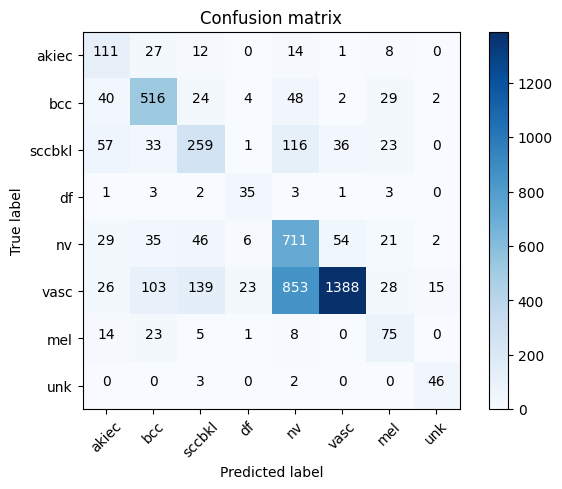

In [43]:
model.eval()
y_label = []
y_predict = []

with torch.no_grad():
    for i,(images,labels) in enumerate(val_dl):
        print(images.size)
        n = images.size(0)
        images = Variable(images).to(device)
        output = model(images)
        pred = torch.argmax(output, dim=1)
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(pred.cpu().numpy())
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
plot_labels = ['akiec', 'bcc','scc' 'bkl', 'df', 'nv', 'vasc','mel','unk']
plot_confusion_matrix(confusion_mtx, plot_labels)


In [44]:
#Classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.40      0.64      0.49       173
         bcc       0.70      0.78      0.73       665
      sccbkl       0.53      0.49      0.51       525
          df       0.50      0.73      0.59        48
          nv       0.41      0.79      0.53       904
        vasc       0.94      0.54      0.68      2575
         mel       0.40      0.60      0.48       126
         unk       0.71      0.90      0.79        51

    accuracy                           0.62      5067
   macro avg       0.57      0.68      0.60      5067
weighted avg       0.73      0.62      0.63      5067



Text(0, 0.5, 'Fraction classified incorrectly')

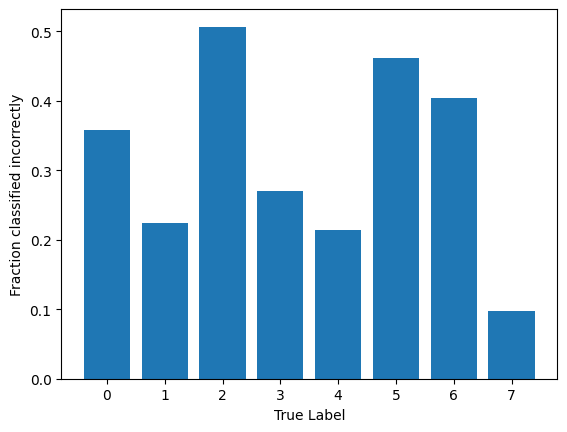

In [45]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(8),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')